# LED Data: Oct 26, 2022
## Import the libraries

In [106]:
import os, sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import TimestreamHelperFunctions as Thf
import PulseTriggeringTools as Ptt

import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf

%matplotlib notebook

### Define some PSD parameters

In [107]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e2
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

## Gather the files

In [168]:
datapath = '/data/USRP_Laser_Data'
series   = "20221028_151414"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

## Load the summary file

In [169]:
md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power']
print(charFs)
print(charZs)
print(rf_power)

[4242.049414 4242.050211 4242.051008]
[0.02425316+0.01291072j 0.02344394+0.01412471j 0.02304509+0.01584702j]
-30


/home/nexus-admin/NEXUS_RF/AnalysisScripts/TimestreamHelperFunctions.py:107: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


### LED voltages
Determine how many LED timestream files there are and get an array of the LED voltages used for each.

In [170]:
voltages = np.array([])

for k in md.keys():
    if 'LaserScan_' in k:
        voltages = np.append(voltages, float(int(1000*md[k]['LEDvoltage'][0]))/1000.)

voltages = np.sort(voltages)
n_volts  = len(voltages)
n_runs   = len(led_files)
print(n_volts, n_runs, "<-- These should be the same")
# print(voltages)

1 1 <-- These should be the same


### Extract the pulse profile
This assumes that each laser timestream is acquired with the same AWG settings.

In [171]:
LED_rate_Hz = 0 # 100.0
lapse_sec   = 0 # 10.0

## Extract the pulse settings, assuming they're all the same
for k in md.keys():
    if 'LaserScan_' in k:
        LED_rate_Hz = md[k]['LEDfreqHz'][0]
        lapse_sec   = md[k]['duration'][0]
        break
LED_rate_Hz = LED_rate_Hz   #*5
print("Pulse f:",LED_rate_Hz,"Hz")
print("Duration:",lapse_sec,"sec")

total_pulses = LED_rate_Hz*lapse_sec

time_btw_pulse = 1./LED_rate_Hz
num_pulses = int(total_pulses * (1 - blank_fraction))
print("Total pulse windows:",total_pulses)
print("Time between pulse arrival:",time_btw_pulse,"sec")
print("Number of windows to look at:",num_pulses)

Pulse f: 100.0 Hz
Duration: 10.0 sec
Total pulse windows: 1000.0
Time between pulse arrival: 0.01 sec
Number of windows to look at: 900


## Create a dataframe of files of interest

In [172]:
## Define the runs of interest
run_dict = {"path": np.sort(led_files) , 
            "file": ["-".join(f.split("/")[-1].split(".")[0:-1]) for f in np.sort(led_files)],
            "Vled": voltages }
n_runs = len(run_dict["path"])
run_df = pd.DataFrame(run_dict)
print("Total runs:",n_runs)

Total runs: 1


In [173]:
run_df

,path,file,Vled
0,/data/USRP_Laser_Data/20221028/20221028_151414...,USRP_LaserOn_3-000V_20221028_151414,3.0


In [174]:
## Fill these columns in later
run_df["pls_sec_s"] = [0.0] *n_runs
run_df["N_pls_fnd"] = [1000]*n_runs # np.zeros(n_runs, dtype=type(None))
run_df["pls_sec_f"] = [10.0]*n_runs # np.zeros(n_runs, dtype=type(None))

In [175]:
## Create an empty column to hold a delta in seconds
run_df["delta_sec"] = [None] *n_runs

## Store some known values
_ = 0
run_df["delta_sec"].iloc[_] = 0.00

## Show the dataframe
run_df

/usr/local/share/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,path,file,Vled,pls_sec_s,N_pls_fnd,pls_sec_f,delta_sec
0,/data/USRP_Laser_Data/20221028/20221028_151414...,USRP_LaserOn_3-000V_20221028_151414,3.0,0.0,1000,10.0,0


## Pick a specific LED voltage

In [176]:
idx  = 0
file = run_df["path"].iloc[idx]
Vled = run_df["Vled"].iloc[idx]
print(series, ":", Vled, "V")

20221028_151414 : 3.0 V


### Clean and make PSDs of the pulsed timestream

Will separate data into  1000 chunks to achieve the requested 1.00e+02  Hz low  end of the PSD
Additional decimation by 20 needed to achieve the requested 5.00e+04  Hz high end of the PSD
Will convert to resonator basis!
doing additional decimation
sampling frequency plugged into welch is 50000
saving pulses to /data/USRP_Laser_Data/20221028/20221028_151414/USRP_LaserOn_3.000V_20221028_151414.h5!
found 14 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 443500)
(1, 443500)
(1, 443500)
(2, 443500)
(1, 443500)
(1, 443500)
number of chunks used to average is 887
Converting to resonator basis!
Fr from fit  [GHz]: 4242.050210980997
Fr min curve [GHz]: 4242.049921608292
Fr from fit  [GHz]: 4242.050210980997
Fr min curve [GHz]: 4242.049921608292


<IPython.core.display.Javascript object>


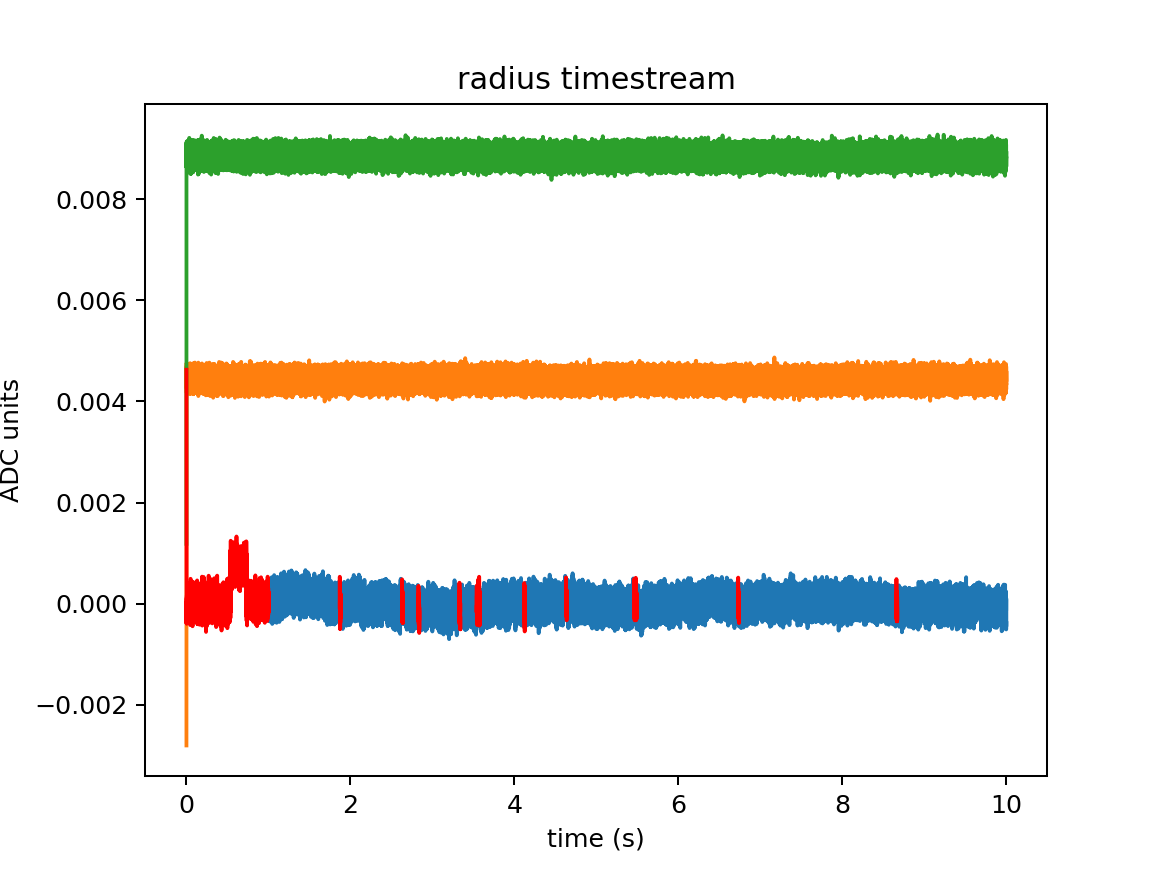

<IPython.core.display.Javascript object>


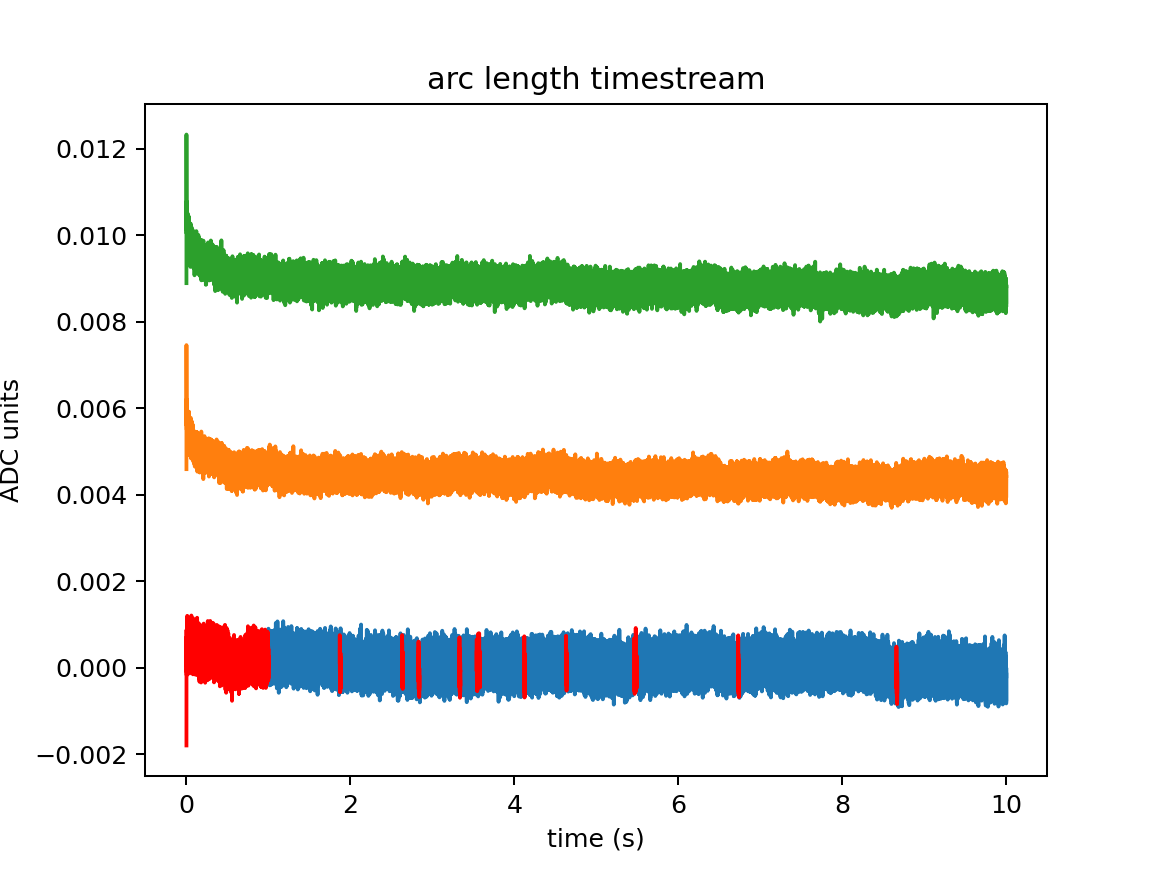

<IPython.core.display.Javascript object>


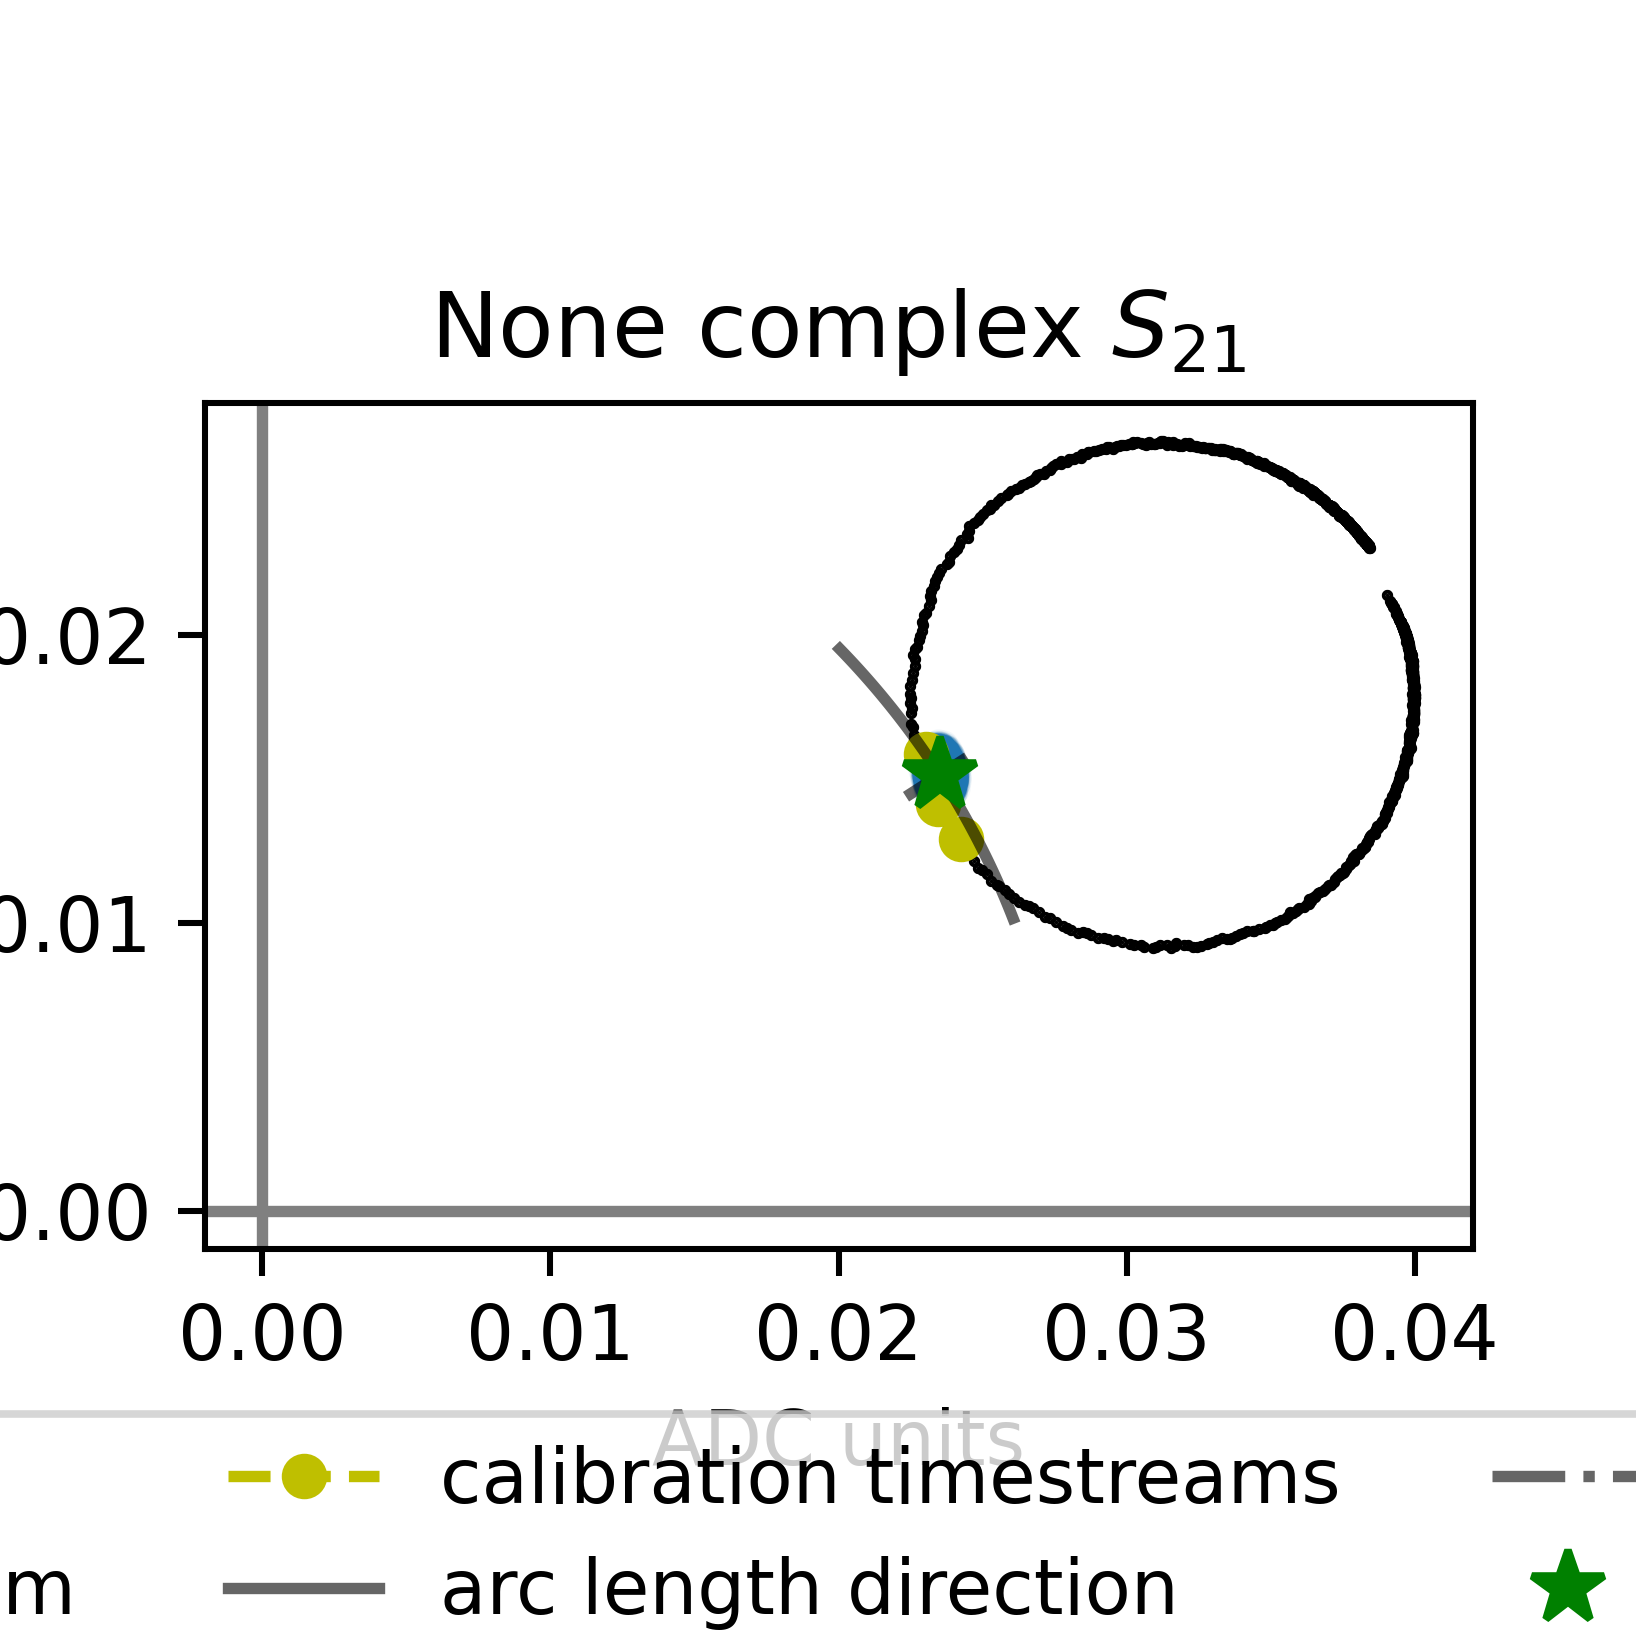

<IPython.core.display.Javascript object>


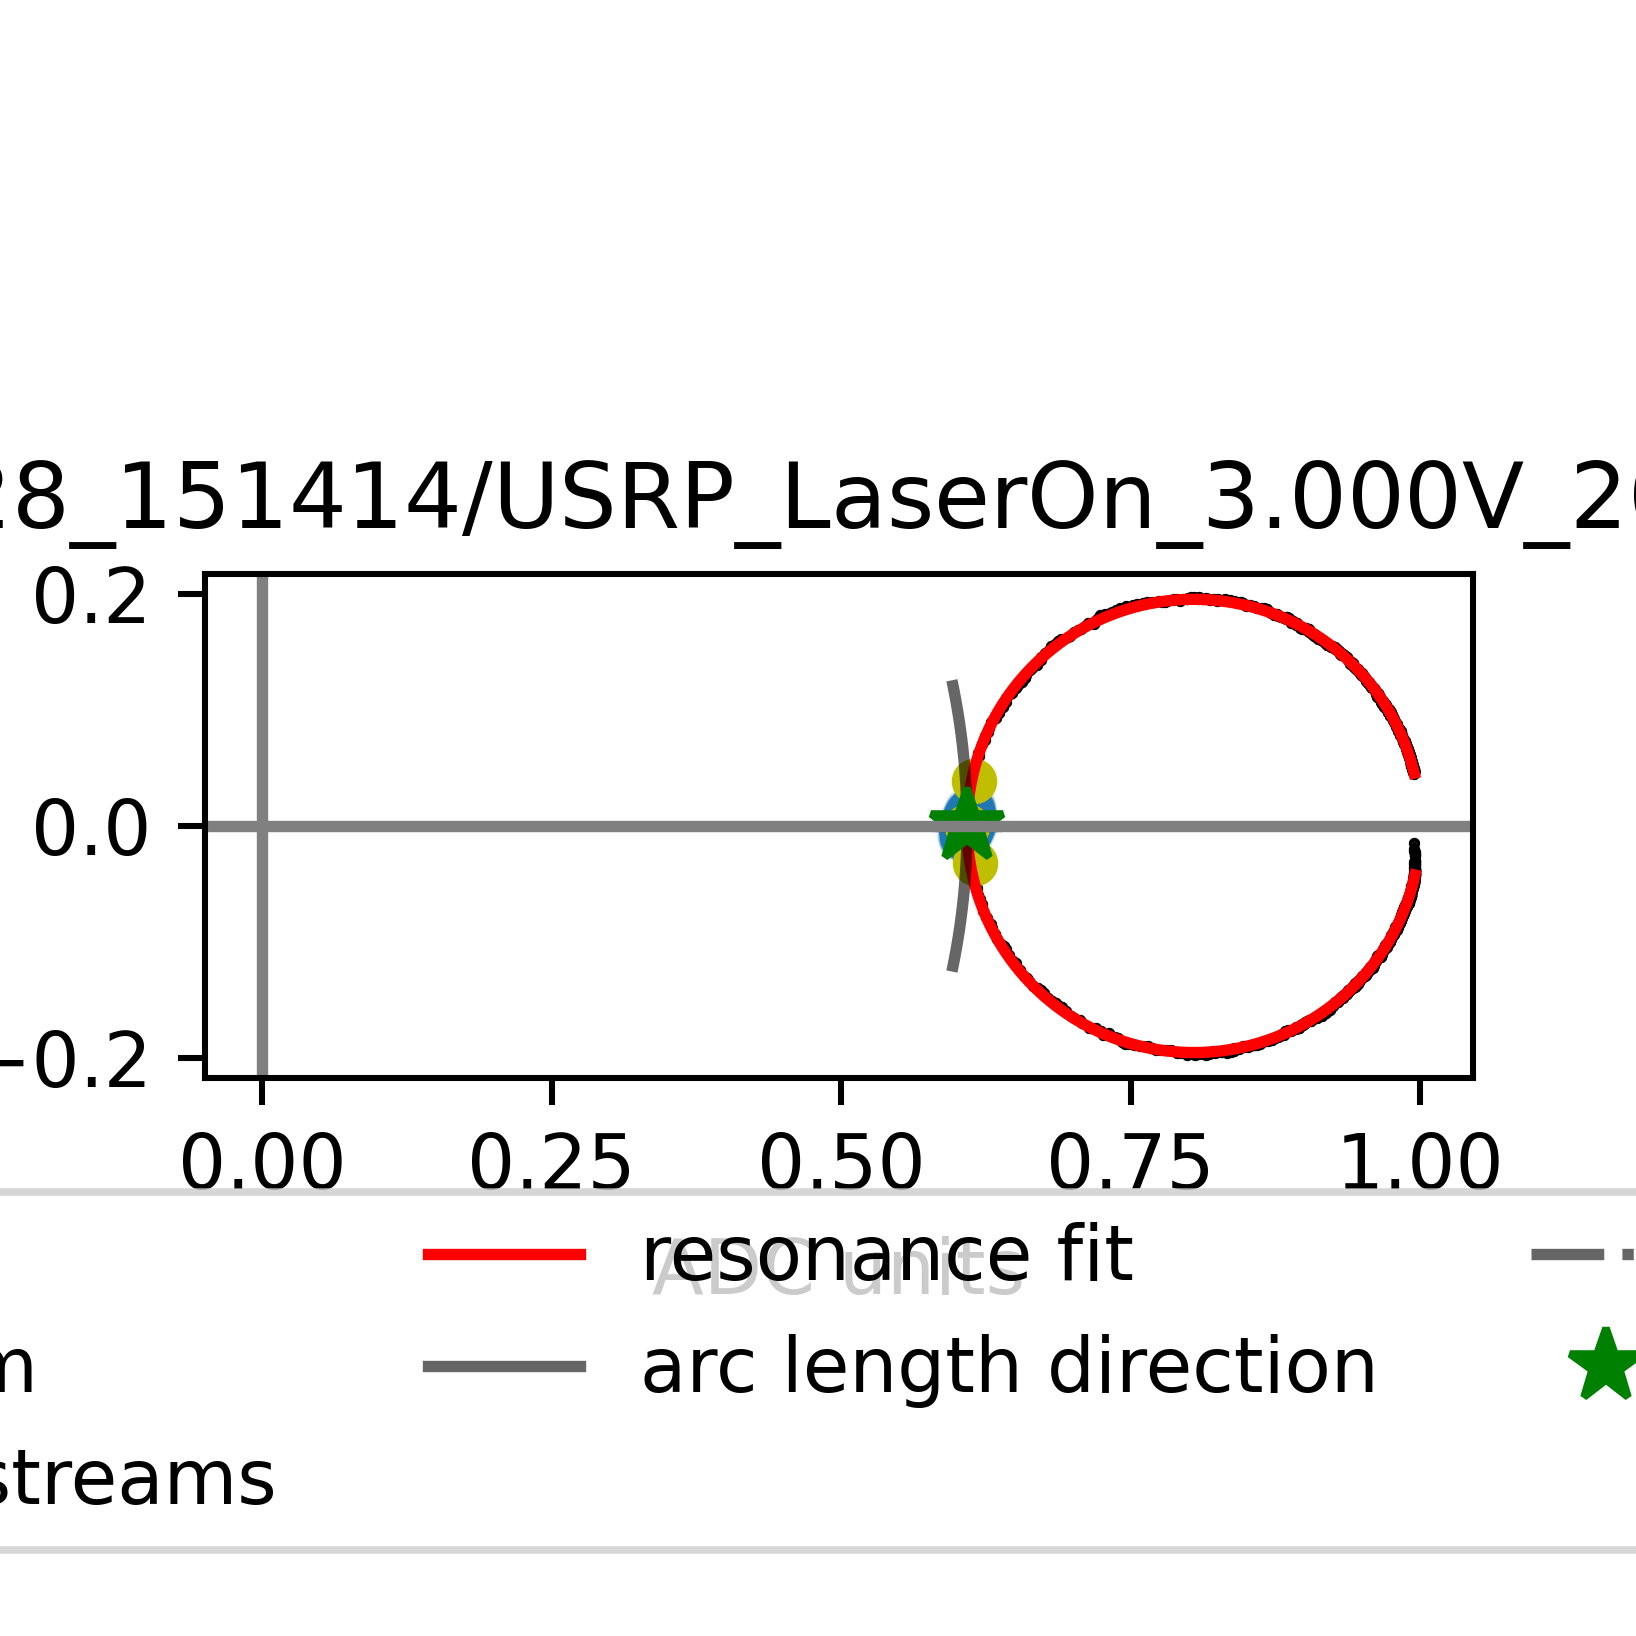

<IPython.core.display.Javascript object>


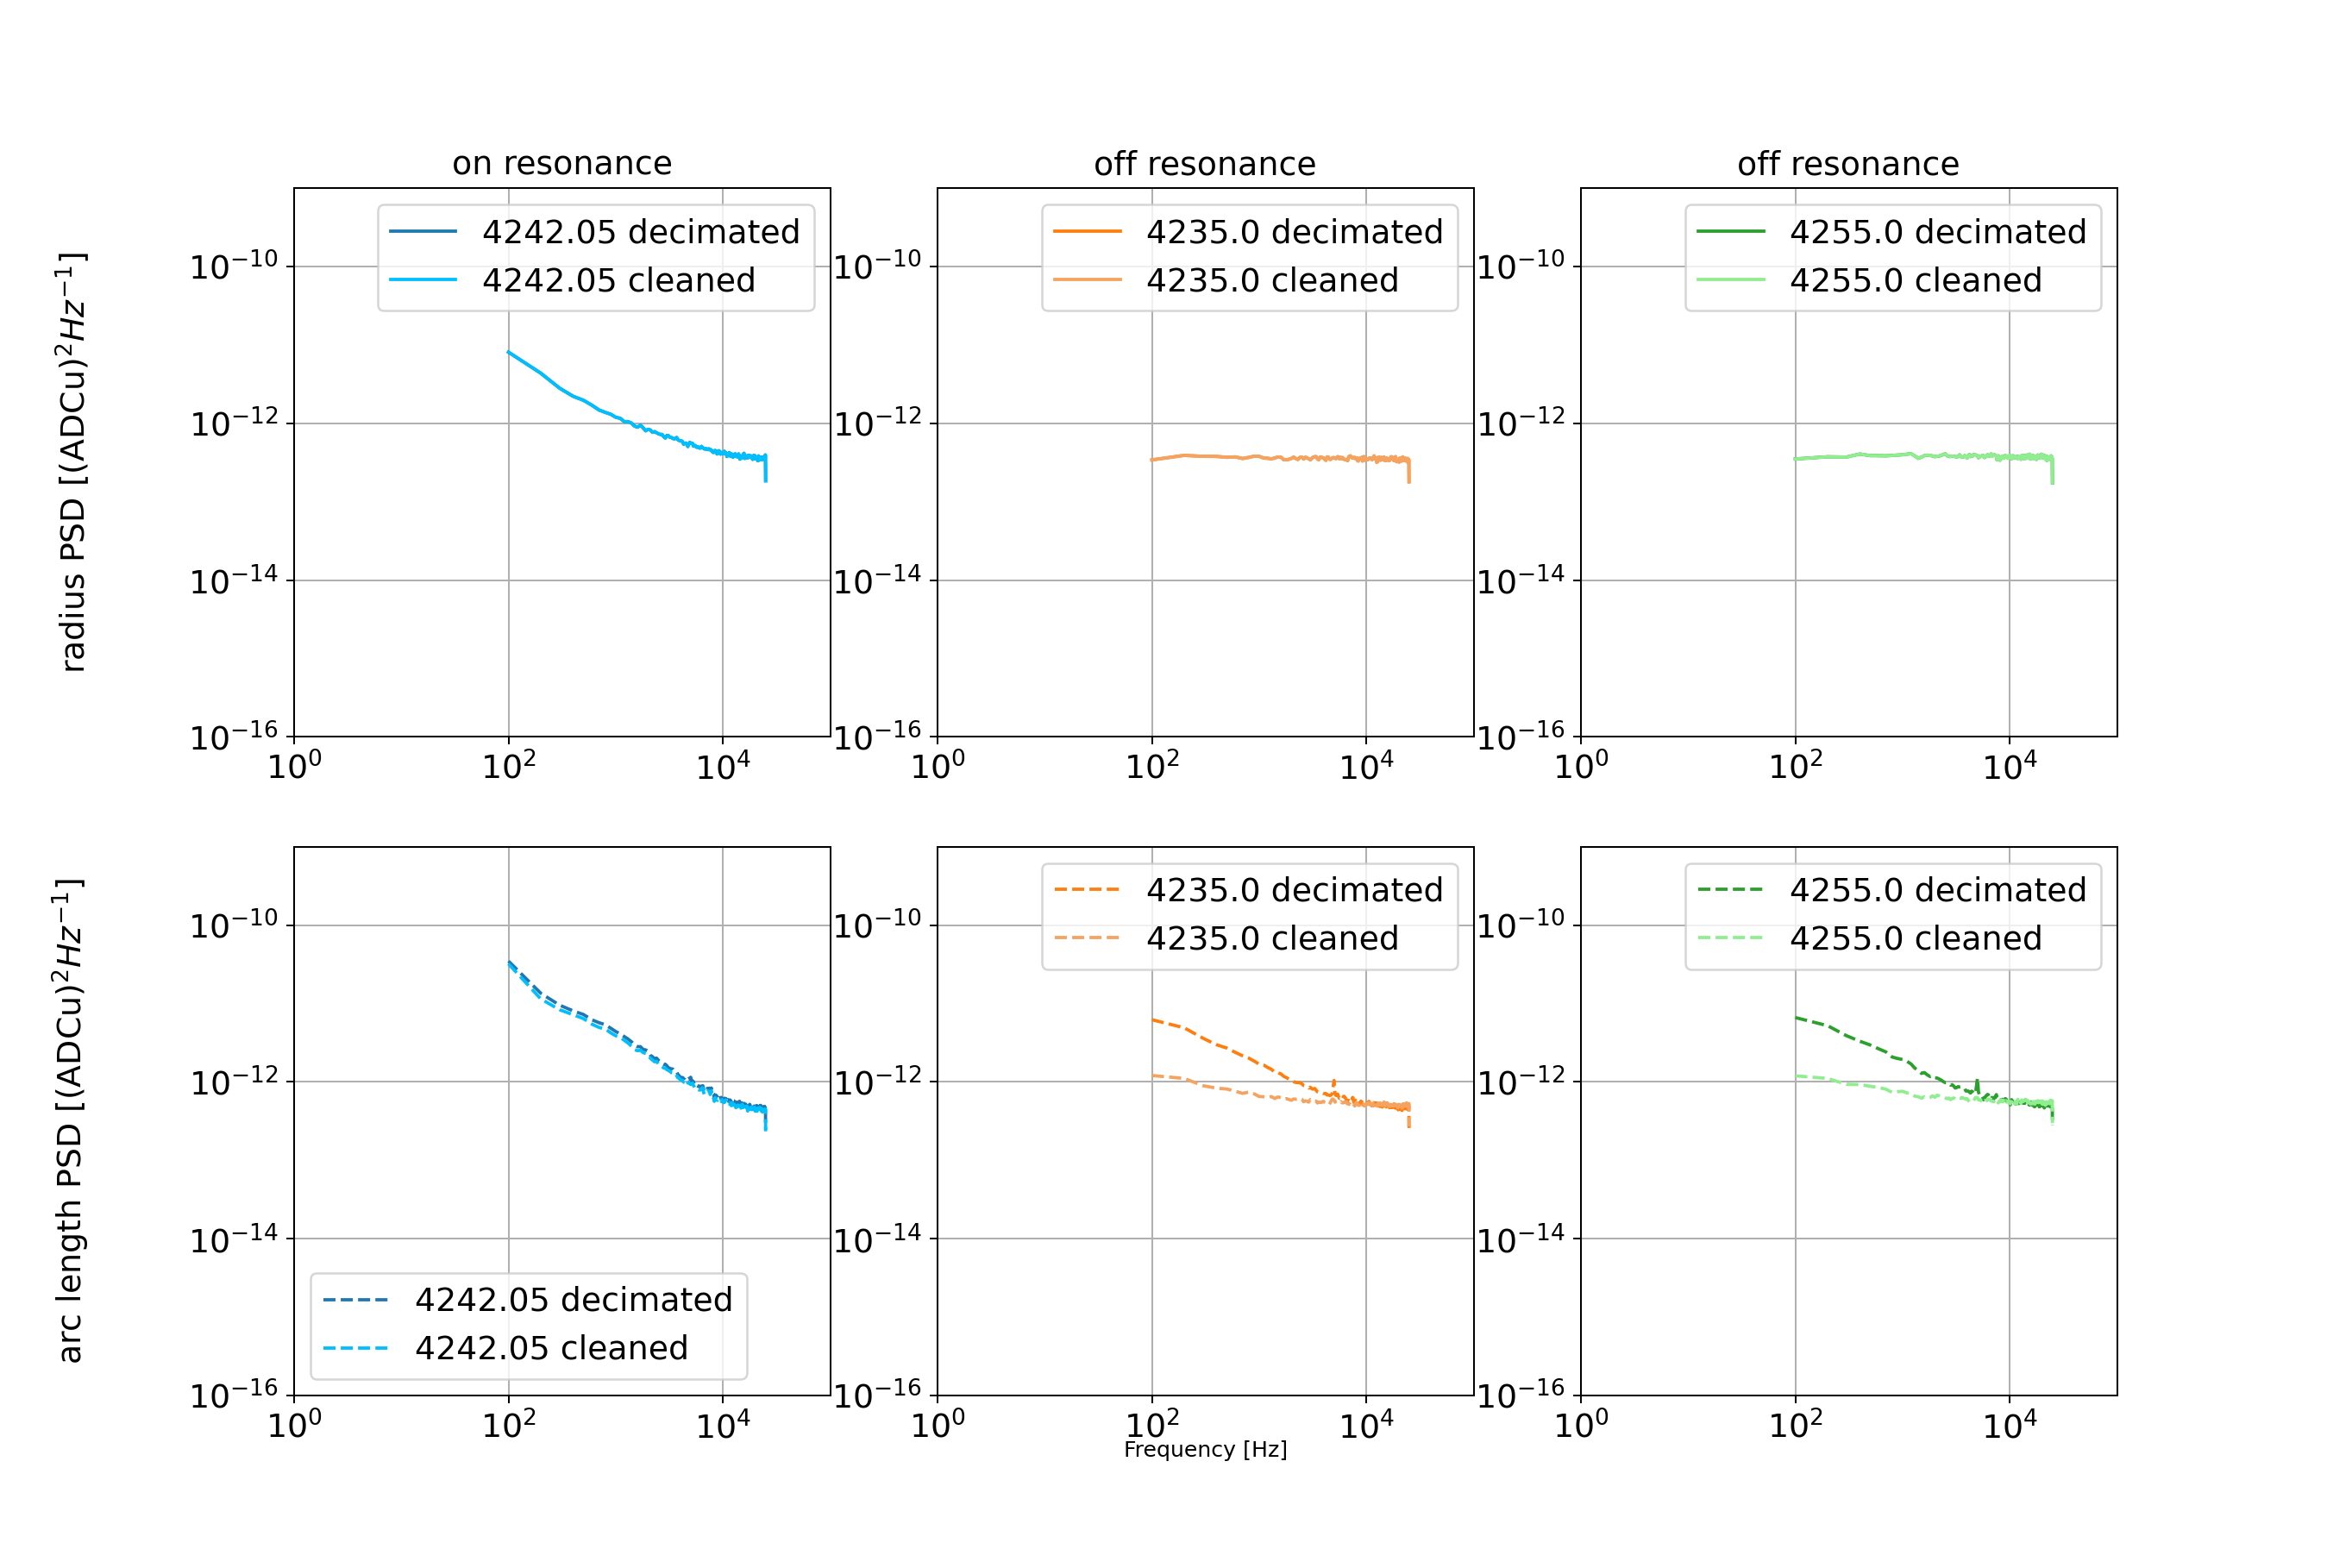

<IPython.core.display.Javascript object>


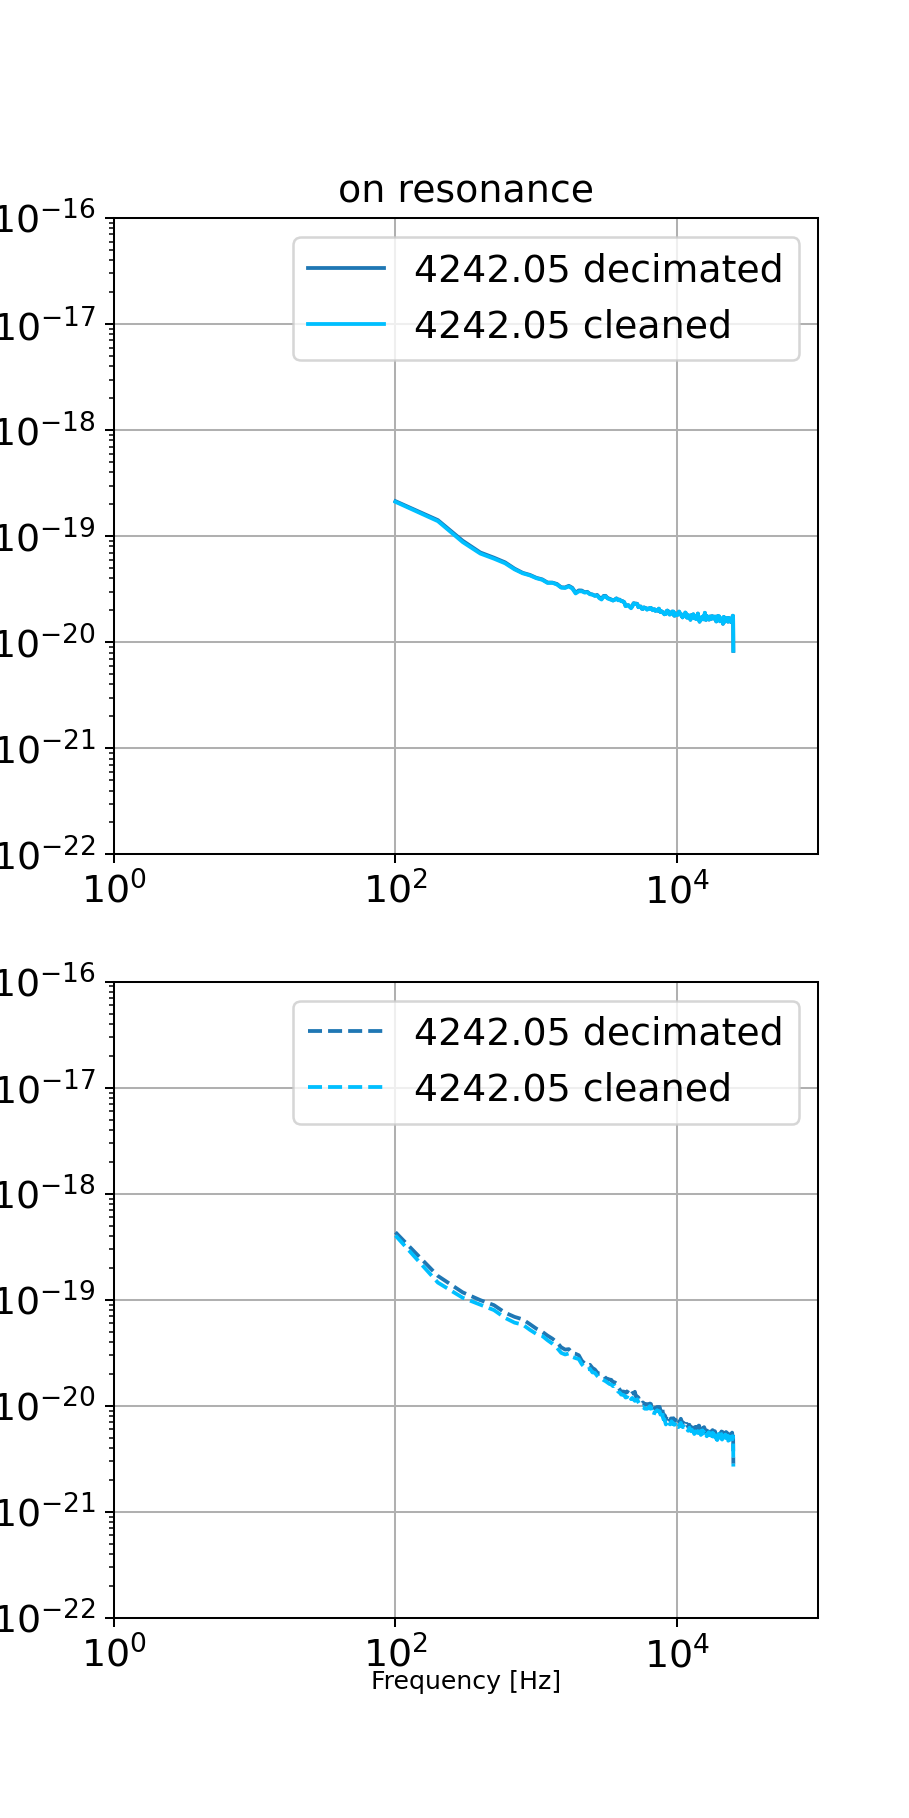

In [177]:
powers_, PSDs_, res_, timestreams_ = Thf.CleanPSDs(
    file, 
    vna_file, 
    PSD_lo_f=chunk_up_to, 
    PSD_hi_f=decimate_down_to, 
    f_transient=blank_fraction, 
    charFs=charFs, 
    charZs=charZs)

### Pull some pulse finding parameters

In [178]:
pulse_start_sec  = run_df["pls_sec_s"].iloc[idx] # 0.0 # 
N_pulses_to_find = run_df["N_pls_fnd"].iloc[idx] # None# 
pulse_end_sec    = run_df["pls_sec_f"].iloc[idx] # 10  # 

### Perform extra decimation

In [179]:
extra_dec = 100

In [180]:
data_noise, data_info = PUf.unavg_noi(file)
time = data_info['time']
time_correction = data_info['sampling period']

data_noise = Prf.average_decimate(data_noise, decimation=extra_dec)
## data_noise is complex values of S21
## can take Re() and Im() to get I, Q
## can take abs() and angle() to get magnitude and phase
time_correction *= extra_dec
time = time[::extra_dec]

### Get a dictionary of the data in this file

In [181]:
res = Ptt.readDataFile(series, base_path='/data/USRP_Laser_Data')

Line Delay file:  USRP_Delay_20221028_151414.h5
VNA scan file:    USRP_VNA_20221028_151414.h5
Noise ts files:   ['USRP_Noise_20221028_151414_delta0.h5']
Laser ts files:   ['USRP_LaserOn_3.000V_20221028_151414.h5']
Summary file:	 noise_averages_20221028_151414.h5


/home/nexus-admin/NEXUS_RF/AnalysisScripts/TimestreamHelperFunctions.py:107: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


### Plot full, decimated, and focused timestream

<IPython.core.display.Javascript object>


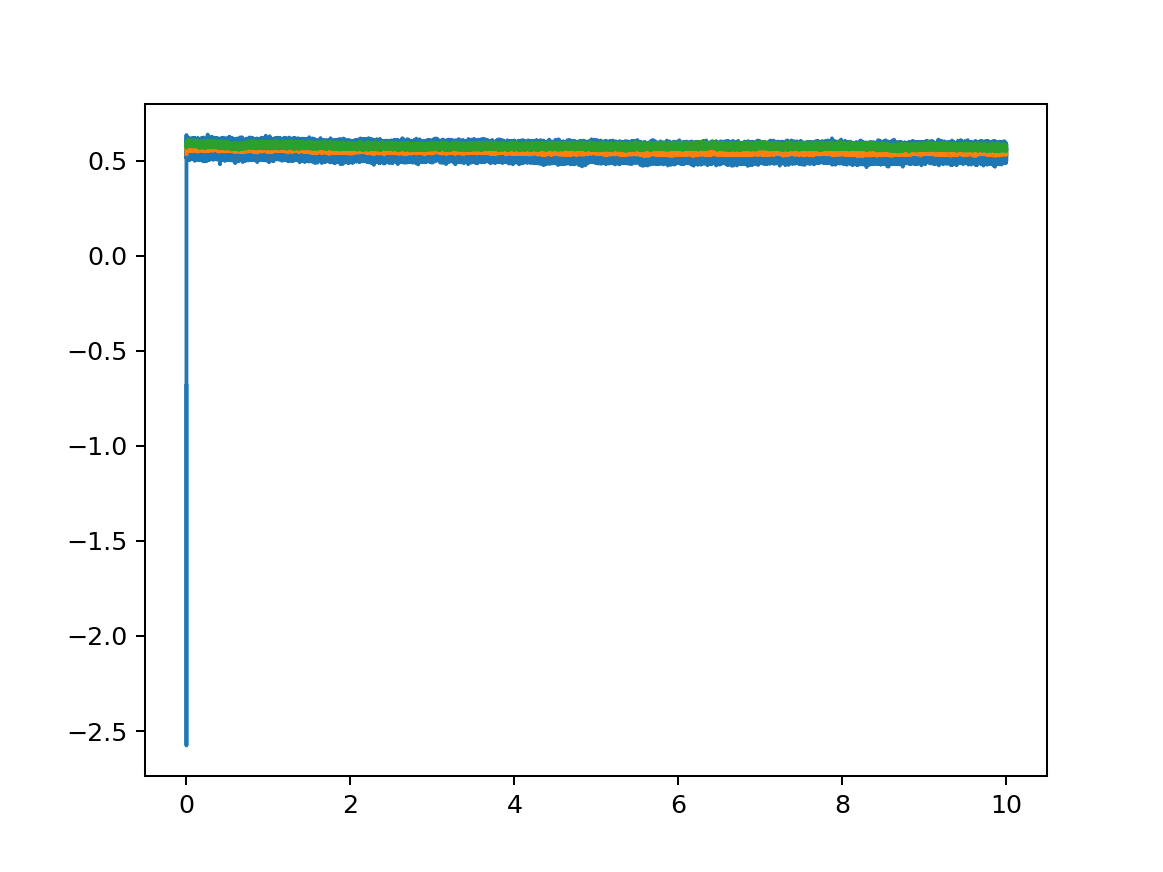

In [182]:
fig = plt.figure()
ax0 = fig.gca()

ax0.plot(res["Time"],res["Phase"])

xavg, yavg = Ptt.movavg_xy(res["Time"],res["Phase"],side_pts=extra_dec)
ax0.plot(xavg, yavg)


ax0.plot(time[(time>pulse_start_sec)*(time<pulse_end_sec)],
         np.angle(data_noise[(time>pulse_start_sec)*(time<pulse_end_sec),0]))

### Show the first 10 pulses

<IPython.core.display.Javascript object>


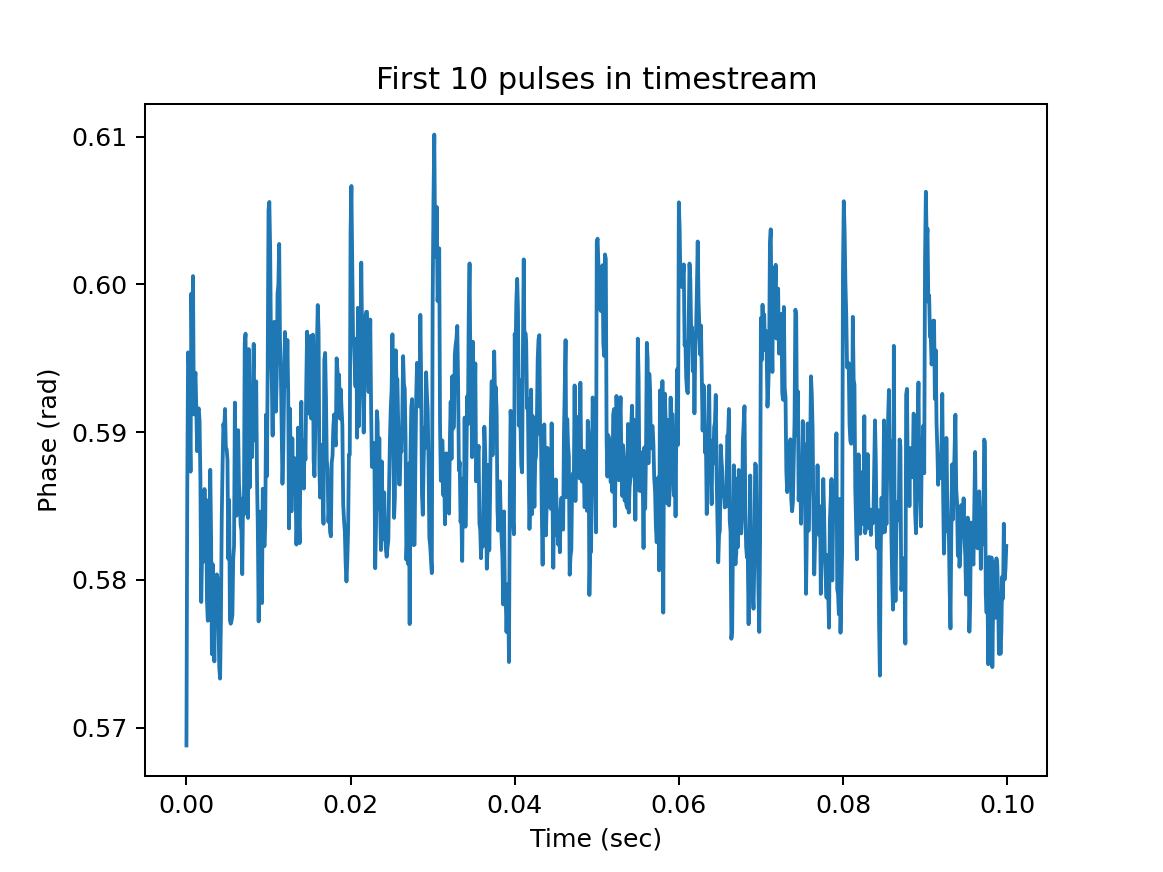

Text(0.5, 1.0, 'First 10 pulses in timestream')

In [183]:
fig = plt.figure()
ax0 = fig.gca()

## Find the first ten pulses
window = 10 * (1/LED_rate_Hz)

ax0.plot(time[(time>pulse_start_sec)*(time<pulse_start_sec+window)],
         np.angle(data_noise[(time>pulse_start_sec)*(time<pulse_start_sec+window),0]))

ax0.set_xlabel("Time (sec)")
ax0.set_ylabel("Phase (rad)")
ax0.set_title("First 10 pulses in timestream")

### Show the first pulse window

<IPython.core.display.Javascript object>


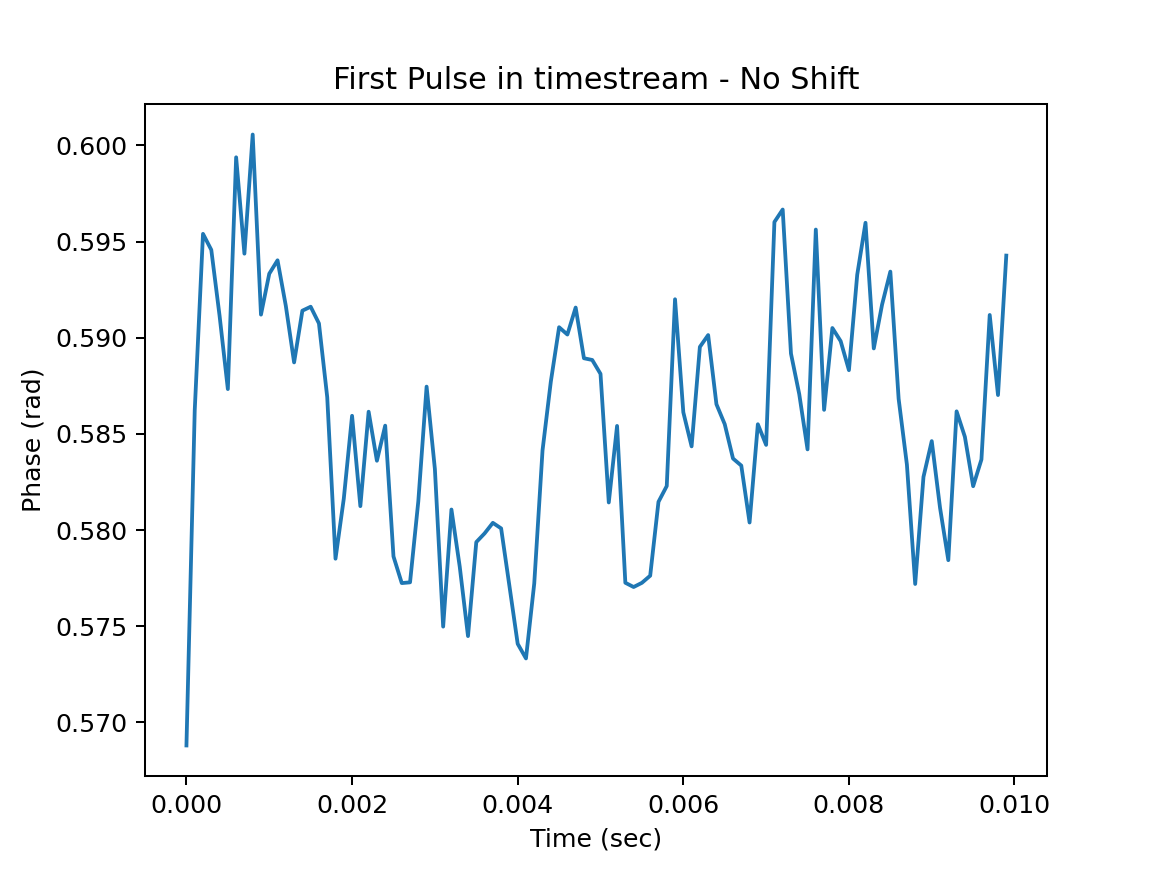

Text(0.5, 1.0, 'First Pulse in timestream - No Shift')

In [184]:
## Find the first ten pulses
window = (1/LED_rate_Hz)

## Window limits
s = pulse_start_sec
e = s + window

fig = plt.figure()
ax0 = fig.gca()
ax0.plot(               time[(time>s)*(time<e)  ],
         np.angle(data_noise[(time>s)*(time<e),0]))

ax0.set_xlabel("Time (sec)")
ax0.set_ylabel("Phase (rad)")
ax0.set_title("First Pulse in timestream - No Shift")

## Algorithm to determine rising edge of first pulse

Rising edge found at 0.0 sec
Use a window starting at 0.0 sec


<IPython.core.display.Javascript object>


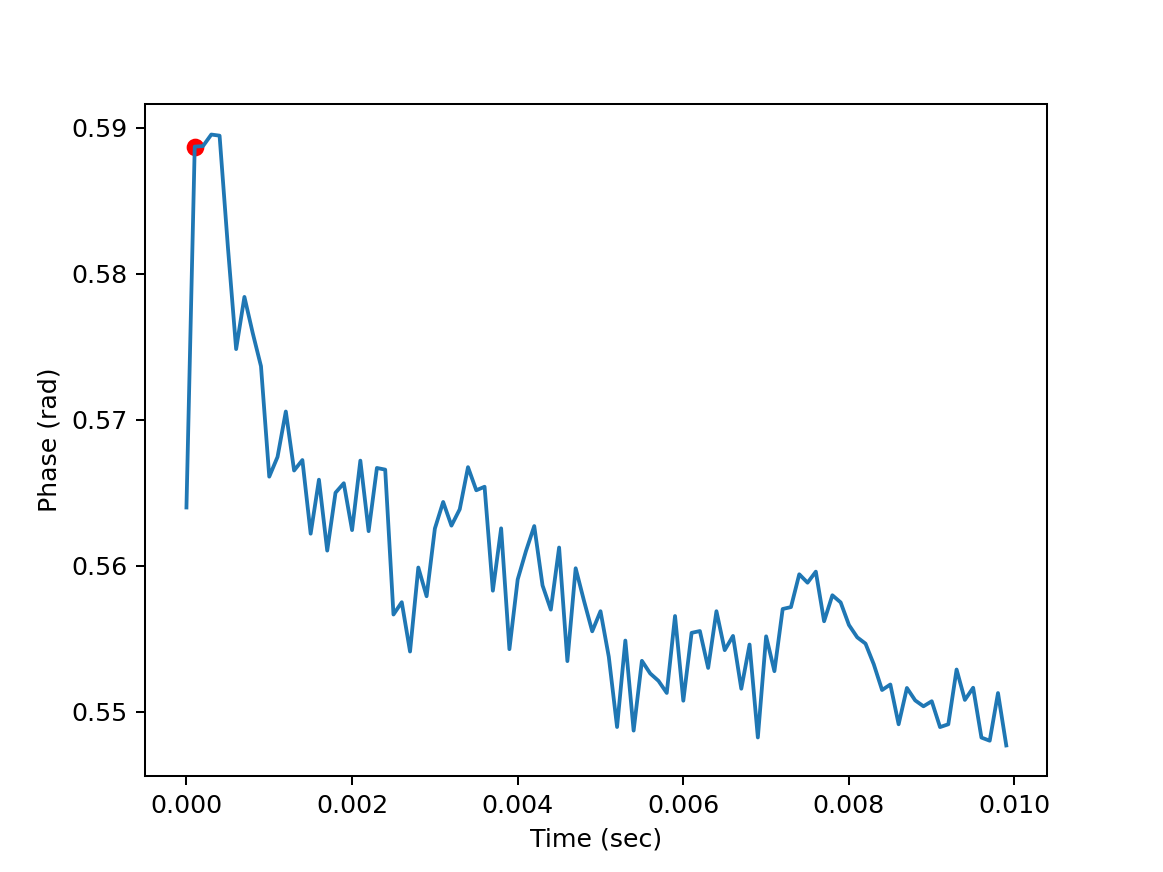

<IPython.core.display.Javascript object>


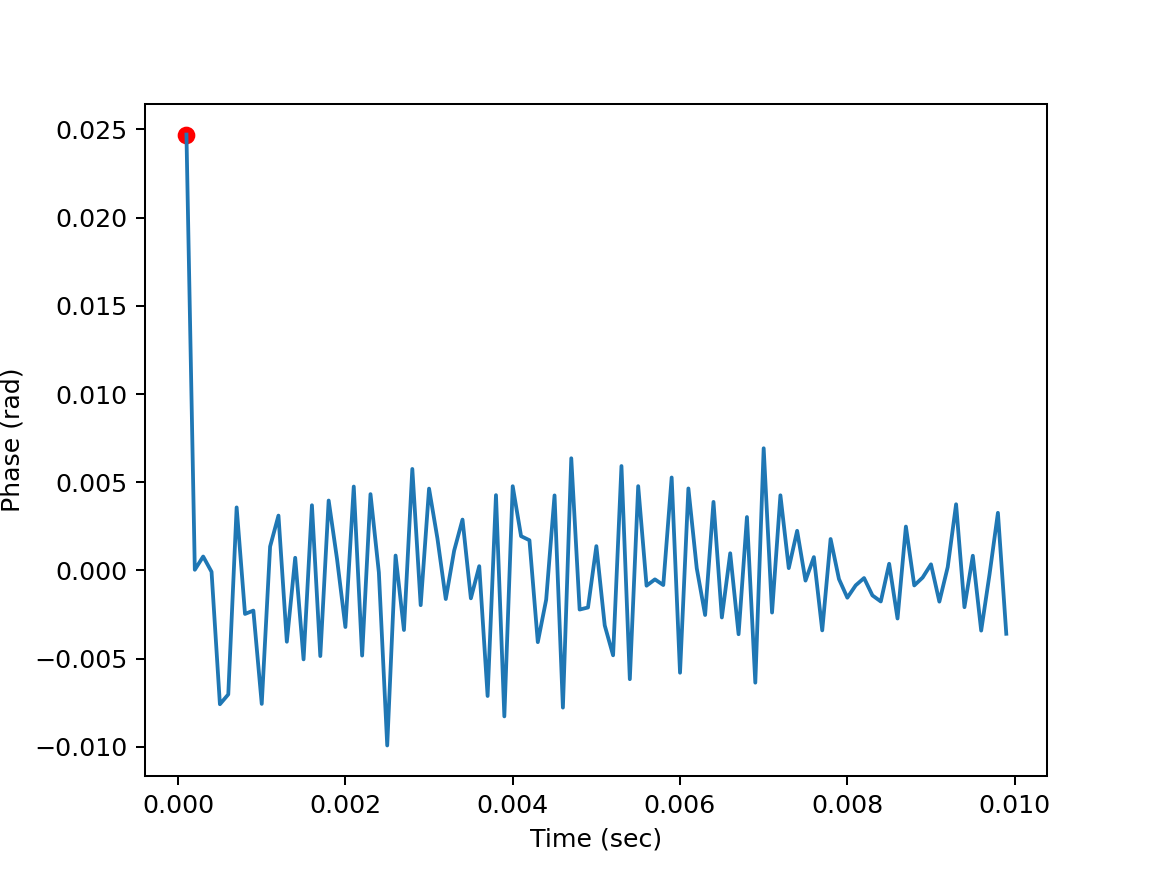

In [147]:
## We want to look at the first window, offset a little bit
## in case we are partially through the first pulse's rising edge

offset_sec = 0.00
delta_sec  = 0.00

## Window limits
s = offset_sec
e = s + window

## Pull the data in this region
xvals =                time[(time>s)*(time<e)  ]
yvals = np.angle(data_noise[(time>s)*(time<e),0])

## Calculate something proportional to slope
yslp  = yvals[1:]-yvals[:-1]

smax  = np.max(yslp)
xmax  = xvals[1:][np.argmax(yslp)]
ymax  = yvals[1:][np.argmax(yslp)]

delta_sec = 0.00 # xmax
print("Rising edge found at",delta_sec+offset_sec,"sec")
print("Use a window starting at",delta_sec,"sec")

fig = plt.figure()
ax0 = fig.gca()
ax0.plot(xvals,yvals)
ax0.set_xlabel("Time (sec)")
ax0.set_ylabel("Phase (rad)")
ax0.scatter(xmax,ymax,c='r',marker='o')

fig = plt.figure()
ax0 = fig.gca()
ax0.plot(xvals[1:],yslp)
ax0.set_xlabel("Time (sec)")
ax0.set_ylabel("Phase (rad)")
ax0.scatter(xmax,smax,c='r',marker='o')

### Show the second window identified by the above algorithm

<IPython.core.display.Javascript object>


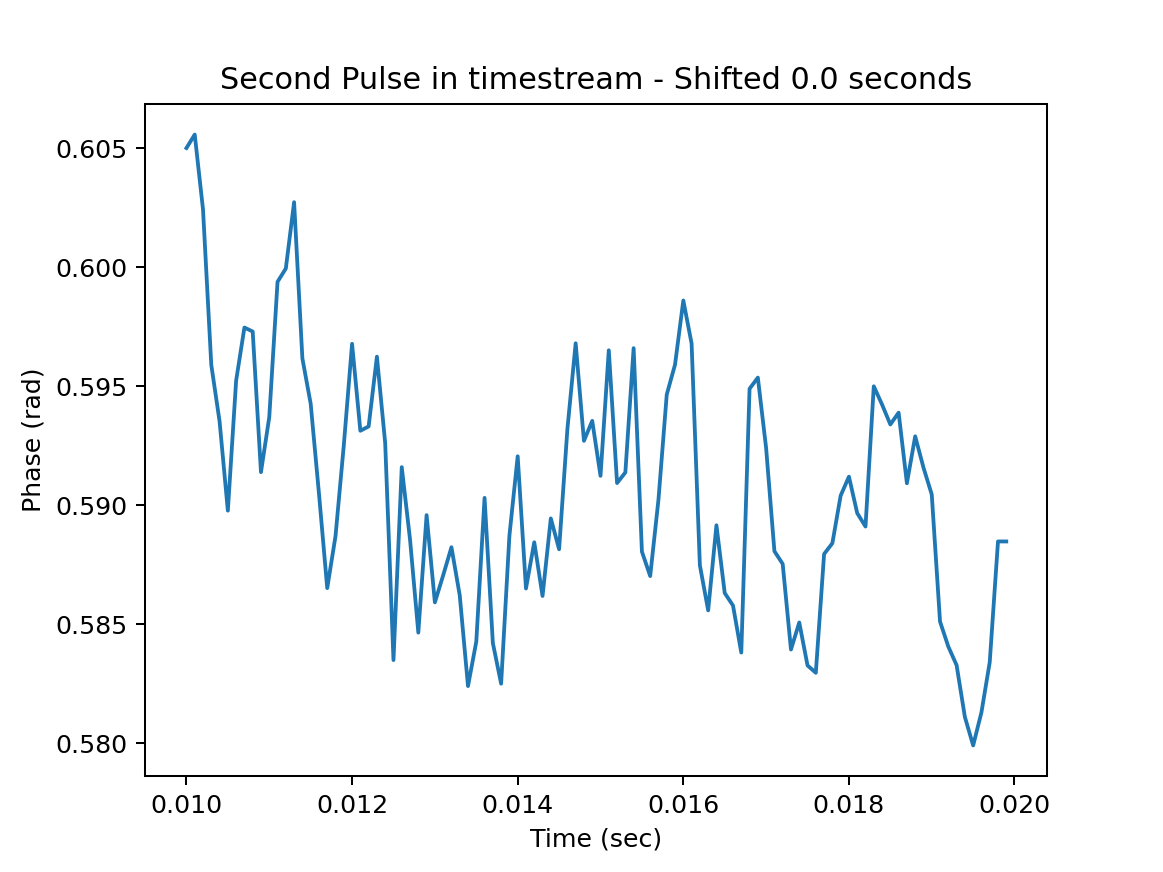

Text(0.5, 1.0, 'Second Pulse in timestream - Shifted 0.0 seconds')

In [185]:
## Window limits
s = pulse_start_sec + delta_sec
e = s + window

fig = plt.figure()
ax0 = fig.gca()
ax0.plot(               time[(time>s+e)*(time<2*e)  ],
         np.angle(data_noise[(time>s+e)*(time<2*e),0]))

ax0.set_xlabel("Time (sec)")
ax0.set_ylabel("Phase (rad)")
ax0.set_title("Second Pulse in timestream - Shifted "+str(delta_sec)+" seconds")

In [150]:
start_search_sec = window + delta_sec

N rising edges: 0
Delta t= []


<IPython.core.display.Javascript object>


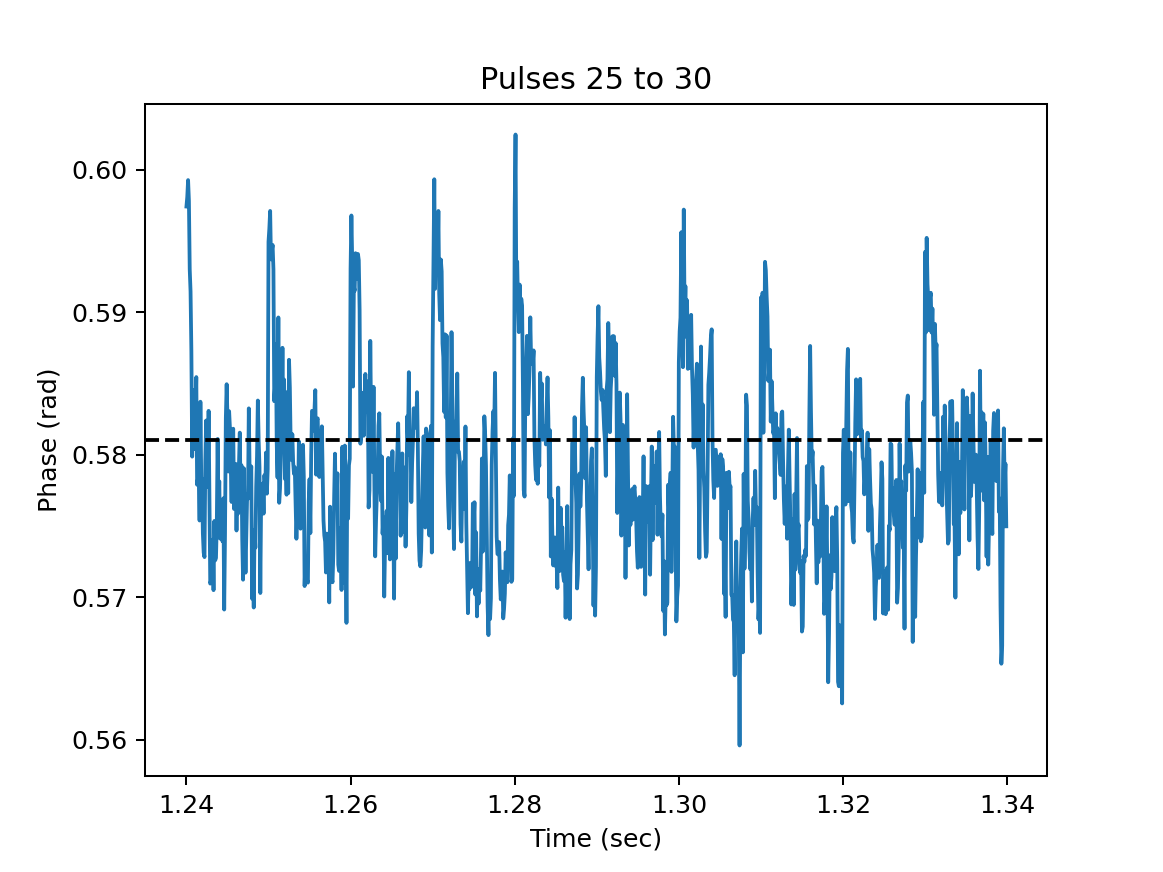

Text(0.5, 1.0, 'Pulses 25 to 30')

In [186]:
## Find some pulses
w_s = 124 * window
w_e = 134 * window

## Window limits
s = pulse_start_sec + delta_sec + w_s
e = s + (w_e-w_s)

## Pull the data from the window
datax =                time[(time>s)*(time<e)  ]
datay = np.angle(data_noise[(time>s)*(time<e),0])

## Find the midpoint
mn = np.min(datay)
mx = np.max(datay)
md = (mx+mn)/2.

## Find every time the wf crosses the midpoint with a positive slope
cx = datax[1:]
cy = datay[1:]-datay[:-1]

cy = cy - 10.*np.mean(np.abs(cy)) ## Probably need to tune the N means to cut
cy[cy<0] = np.nan
re = cx[cy>0]
print("N rising edges:", len(re))

## Get the time difference between each subsequent pulse
print("Delta t=",re[1:]-re[:-1])

## Draw the plot
fig = plt.figure()
ax0 = fig.gca()

ax0.plot(datax,datay)
ax0.scatter(re,md*np.ones(len(re)),c='r')
ax0.axhline(y=md,color='k',ls='--')

ax0.set_xlabel("Time (sec)")
ax0.set_ylabel("Phase (rad)")
ax0.set_title("Pulses 25 to 30")

<IPython.core.display.Javascript object>


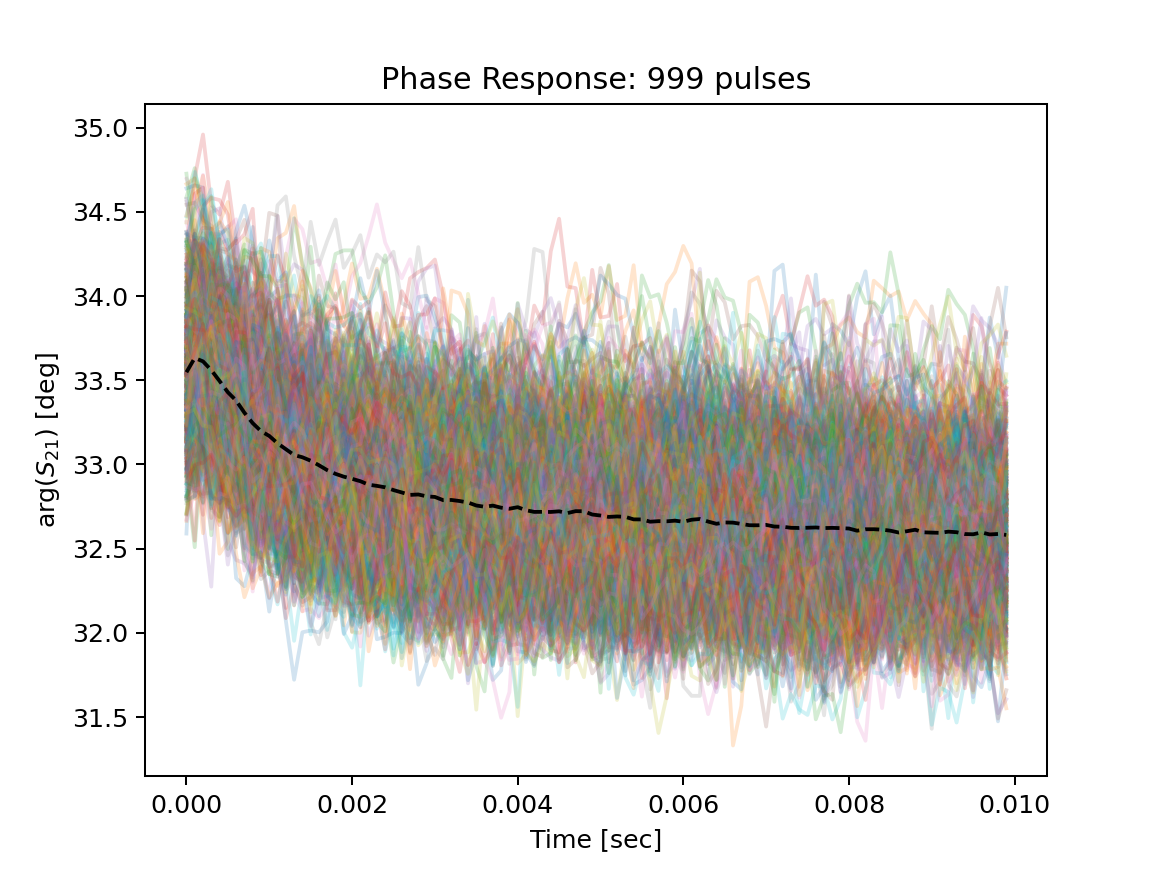

Text(0, 0.5, '$\\mathrm{arg}(S_{21})$ [deg]')

In [187]:
plot_vs_time = True
avg, npulses, bl, win = Ptt.StackPulses(np.angle(data_noise[:,0])*180/np.pi, 
                                        pulse_start_sec,
                                        pulse_rate_Hz = LED_rate_Hz,
                                        win_fac       = 1.00, 
                                        sample_rate   = 1e6/extra_dec,
                                        Npulses       = None, 
                                        bl_subtract   = False, 
                                        show_plots    = True, 
                                        plot_time     = plot_vs_time)
plt.gca().set_title("Phase Response: "+str(npulses)+" pulses")
plt.gca().set_xlabel(r"Decimated sample index")
if plot_vs_time:
    plt.gca().set_xlabel(r"Time [sec]")
plt.gca().set_ylabel(r"$\mathrm{arg}(S_{21})$ [deg]")

In [ ]:
plot_vs_time = True
avg, npulses, bl, win = Ptt.StackPulses(np.abs(data_noise[:,0]), pulse_start_sec,
                                        win_fac=0.95, Npulses=N_pulses_to_find, sample_rate=1e6/extra_dec,
                                        bl_subtract=False, show_plots=True, plot_time=plot_vs_time)
plt.gca().set_title("Magnitude Response: "+str(npulses)+" pulses")
plt.gca().set_xlabel(r"Decimated sample index")
if plot_vs_time:
    plt.gca().set_xlabel(r"Time [sec]")
plt.gca().set_ylabel(r"$|S_{21}|$ [dBm]")

In [ ]:
pidx = int(npulses*np.random.rand())
Ptt.PlotPulse(data_noise[:,0], pulse_start_sec, p_index=pidx, fig_obj=None,
              pulse_rate_Hz=pulse_rate_Hz, win_fac=0.75, sample_rate=1e6/extra_dec,
              baseline=None, complx=True)
ax0 = plt.gca()
ax0.set_title("Pulse #"+str(pidx))
ax0.set_xlabel("Real")
ax0.set_ylabel("Imaginary")
ax0.set_aspect('equal', 'box')

In [ ]:
VNA_f, VNA_z = PUf.read_vna(vna_file)

In [ ]:
fig = plt.figure()
ax0 = plt.gca()
for i in np.arange(npulses):
    Ptt.PlotPulse(data_noise[:,0], pulse_start_sec, p_index=i, fig_obj=fig,
                  pulse_rate_Hz=pulse_rate_Hz, win_fac=0.75, sample_rate=1e6/extra_dec,
                  baseline=None, complx=True)
ax0.set_title("Total Pulses: "+str(npulses))
ax0.set_xlabel("Real")
ax0.set_ylabel("Imaginary")
ax0.set_aspect('equal', 'box')

In [ ]:
fig = plt.figure()
ax0 = plt.gca()
for i in np.arange(npulses):
    Ptt.PlotPulse(data_noise[:,0], pulse_start_sec, p_index=i, fig_obj=fig,
                  pulse_rate_Hz=pulse_rate_Hz, win_fac=0.75, sample_rate=1e6/extra_dec,
                  baseline=None, complx=True)
ax0.set_title("Total Pulses: "+str(npulses))
ax0.set_xlabel("Real")
ax0.set_ylabel("Imaginary")
ax0.set_aspect('equal', 'box')


xlims = ax0.get_xlim()
ylims = ax0.get_ylim()
ax0.plot(np.real(VNA_z[(VNA_f>4.24205e3)*(VNA_f<4.24235e3)]),
         np.imag(VNA_z[(VNA_f>4.24205e3)*(VNA_f<4.24235e3)]),
         "k-",marker='o')
ax0.set_xlim(xlims)
ax0.set_ylim(ylims)

In [ ]:
fig = plt.figure()
ax0 = plt.gca()
for i in np.arange(npulses):
    Ptt.PlotPulse(data_noise[:,0], pulse_start_sec, p_index=i, fig_obj=fig,
                  pulse_rate_Hz=pulse_rate_Hz, win_fac=0.75, sample_rate=1e6/extra_dec,
                  baseline=None, complx=True)
ax0.set_title("Total Pulses: "+str(npulses))
ax0.set_xlabel("Real")
ax0.set_ylabel("Imaginary")
ax0.set_aspect('equal', 'box')

ax0.plot(np.real(VNA_z[(VNA_f>4.24205e3)*(VNA_f<4.24235e3)]),
         np.imag(VNA_z[(VNA_f>4.24205e3)*(VNA_f<4.24235e3)]),
         "k-",marker='o')

In [ ]:
## Size of signal
z_roi = VNA_z[(VNA_f>4.24205e3)*(VNA_f<4.24235e3)]
i_min = np.argmin(np.real(z_roi))
i_max = np.argmax(np.real(z_roi))
rad   = np.abs(z_roi[i_max]-z_roi[i_min])
print(rad)

In [ ]:
## Size of noise
noise = 0.0003247
snr   = rad/noise
print("SNR ~",snr)

In [ ]:
dec_fac = 100

## Create a figure to house the average phase responses
fig = plt.figure()
ax0 = fig.gca()

ax0.set_title("Phase Response")
ax0.set_xlabel("Time [ms]")
ax0.set_ylabel(r"$\mathrm{arg}(S_{21})$ [rad]")

## Now loop over the first three files and extract the average phase response 
for j in [0,1,2]:
    series = run_df["series"].iloc[j]
    Vled   = run_df["Vled"].iloc[j]
    
    ## Get the timestream and decimate it
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series)

    data_noise, data_info = PUf.unavg_noi(tone_files[0])
    data_noise = Prf.average_decimate(data_noise, decimation=dec_fac)

    avg, npulses, bl, win = Ptt.StackPulses(np.angle(data_noise[:,0]), run_df["pls_sec_s"].iloc[j],
                                        win_fac=0.75, Npulses=run_df["N_pls_fnd"].iloc[j], sample_rate=1e6/extra_dec,
                                        bl_subtract=True, show_plots=False, plot_time=True)
    
    time_range = np.arange(len(avg))/(1e6/extra_dec)
    time_range = time_range - time_range[np.argmax(avg[1:]-avg[:-1])]
    
    ax0.plot(time_range*1e3,avg,linestyle="--",marker="o",label=series+" - Vled = "+str(Vled)+"V")
    
ax0.legend(loc='best')

In [ ]:
dec_fac = 100

## Create a figure to house the average phase responses
fig = plt.figure()
ax0 = fig.gca()

ax0.set_title("Magnitude Response")
ax0.set_xlabel("Time [ms]")
ax0.set_ylabel(r"$|S_{21}|$ [dBm]")

## Now loop over the first three files and extract the average phase response 
for j in [0,1,2]:
    series = run_df["series"].iloc[j]
    Vled   = run_df["Vled"].iloc[j]
    
    ## Get the timestream and decimate it
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series)

    data_noise, data_info = PUf.unavg_noi(tone_files[0])
    data_noise = Prf.average_decimate(data_noise, decimation=dec_fac)

    avg, npulses, bl, win = Ptt.StackPulses(np.abs(data_noise[:,0]), run_df["pls_sec_s"].iloc[j],
                                        win_fac=0.75, Npulses=run_df["N_pls_fnd"].iloc[j], sample_rate=1e6/extra_dec,
                                        bl_subtract=True, show_plots=False, plot_time=True)
    
    time_range = np.arange(len(avg))/(1e6/extra_dec)
    time_range = time_range - time_range[np.argmax(avg[1:]-avg[:-1])]
    
    ax0.plot(time_range*1e3,avg,linestyle="--",marker="o",label=series+" - Vled = "+str(Vled)+"V")
    
ax0.legend(loc='best')